<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/03a_training_phasenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [6]:
# !pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [7]:
# try:
#     import obspy
#     obspy.read()
# except TypeError:
#     # Needs to restart the runtime once, because obspy only works properly after restart.
#     print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
#     exit()

As training data we use the ETHZ dataset. Note that we set the sampling rate to 100 Hz to ensure that all examples are consistent in terms of sampling rate. We split the data into training, development and test sets according to the splits provided.

In [8]:
import seisbench.models as sbm
import seisbench.generate as sbg
import numpy as np
import seisbench.data as sbd
import torch
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [9]:
from config import load_config
cfg = load_config('Kaki-cfg.yml')
print(cfg)

path: inp: /home/ekarkooti/Documents
catalog: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Catalog-get-1403-06-10/kaki_all.out
stream: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/raw-gcf-data
network_details: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Kaki_station-sensor-region-coords.csv
dataset: ./Kaki-Dataset-All_1403-06-12
model: path: ./model
name: PhaseNet_Kaki_1403-06





In [10]:
from pathlib import Path

base_path = Path(cfg.path.dataset)

data = sbd.WaveformDataset(base_path, sampling_rate=100)
train, dev, test = data.train_dev_test()

2024-09-02 15:42:51,092 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [11]:
l = len(data)
print(l)
data.metadata['split'][0: l-l//4] = 'train'
data.metadata['split'][l-l//4: l-l//8] = 'dev'
data.metadata['split'][l-l//8: ] = 'test'



287


/tmp/ipykernel_18032/3078054660.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.metadata['split'][0: l-l//4] = 'train'
/tmp/ipykernel_18032/3078054660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [12]:
train, dev, test = data.train_dev_test()
print(train, dev, test)

Unnamed dataset - 216 traces Unnamed dataset - 36 traces Unnamed dataset - 35 traces


## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [13]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A normalization, consisting of demeaning and amplitude normalization.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label

In [14]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 256 samples. This batch size should fit on most hardware.

Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [15]:
base_path = Path(cfg.path.model.path) / cfg.path.model.name

model = sbm.PhaseNet.load(base_path)
model_org = sbm.PhaseNet.from_pretrained('original')


## Evaluating the model

Not that we trained the model, we can evaluate it. First, we'll check how the model does on an example from the development set. Note that the model will most likely not be fully trained after only five epochs.

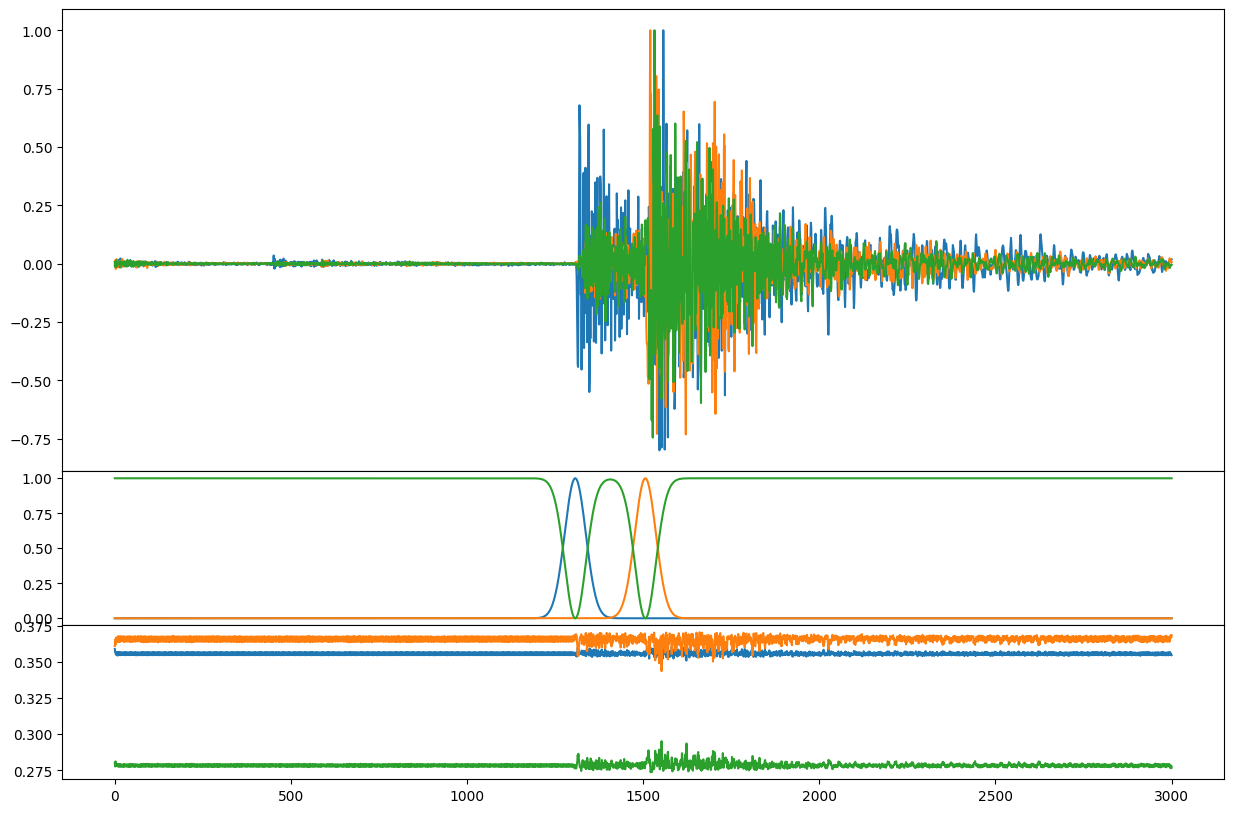

In [16]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

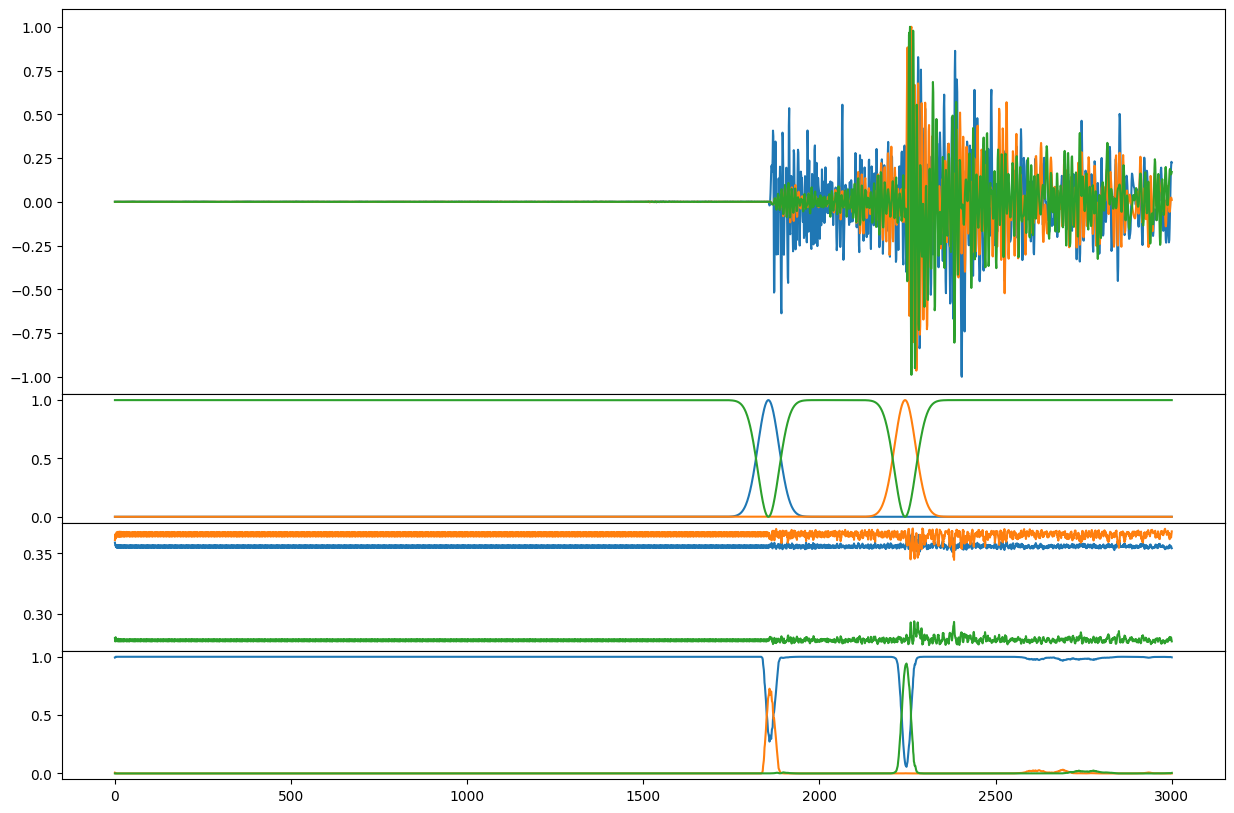

In [17]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)


with torch.no_grad():
    pred = model_org(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[3].plot(pred.T)

As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

As we trained the model on Swiss data, we use an example event from Switzerland. Note that we deliberately chose a rather easy example, as the model is not fully trained after the low number of epochs. The exact performance of the model will vary depending, because the model training and initialization involves random aspects.

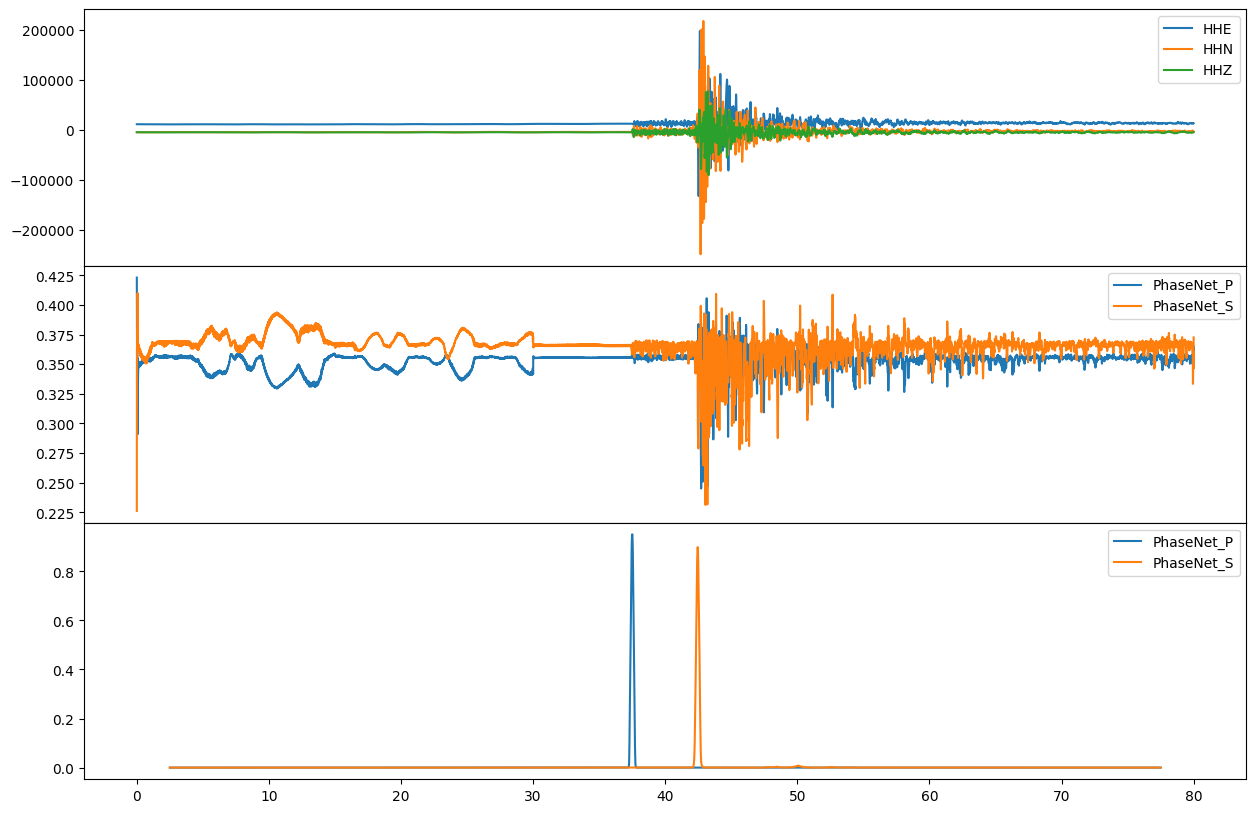

In [18]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)
annotations_org = model_org.annotate(stream)


fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
offset_org = annotations_org[0].stats.starttime - stream[0].stats.starttime

for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)
    if annotations_org[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[2].plot(annotations_org[i].times() + offset_org,
                    annotations_org[i].data,
                    label=annotations_org[i].stats.channel)

axs[0].legend()
axs[1].legend()
axs[2].legend()

## Remarks

As discussed in the data basics tutorial, loading a SeisBench dataset only means loading the metadata into memory. The waveforms are only loaded once they are requested to save memory. By default, waveforms are **not** cached in memory. For training, this means that the data needs to be read from the file in every epoch again. Depending on your hardware, this will take a lot of time. To solve this issue, you can set the `cache` option, when creating the dataset. Then, all you have to do is call `preload_waveforms` and the data will be loaded into memory and automatically cached. For most practical applications, this option is recommended.